In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
import math
import datetime
import  matplotlib.pyplot as plt

In [2]:
train_m = pd.read_csv('/Users/vsokolov/papers/dl-stats/data/airbnb/train_starting.csv', index_col=0)
test_m = pd.read_csv('/Users/vsokolov/papers/dl-stats/data/airbnb/test_starting.csv', index_col = 0)

In [3]:
#original column names of training data
print list(train_m.columns)

['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination', 'lag_account_created', 'lag_first_active', 'lag_account_created_first_active', 'bookings', 'population_in_thousands', 'sum_secs_elapsed', 'counts']


In [4]:
#the toremove is a list of columns to be removed from the original dataset
excl = list(train_m.columns)
toremove = ['id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'population_in_thousands',
            'lag_account_created', 'bookings', 'lag_first_active', 
            #'lag_account_created_first_active', 
              'country_destination'] 
map(lambda x: excl.remove(x), toremove)

[None, None, None, None, None, None, None, None, None]

In [5]:
##applying to remove to the dataset and left with a clean training and test dataset
train_xcl = train_m.loc[:, excl]
test_xcl = test_m.loc[:, excl]

In [6]:
#convert training and test x data into a sparce matrix dictionary
from sklearn.feature_extraction import DictVectorizer

frames = [train_xcl, test_xcl]
all_data = pd.concat(frames)
all_data = all_data.T.to_dict().values()
train_xdic = train_xcl.T.to_dict().values()
test_xdic = test_xcl.T.to_dict().values()

vec = DictVectorizer()
vec.fit(all_data)
train_xvec = vec.transform(train_xdic)
test_xvec = vec.transform(test_xdic)

/Users/vsokolov/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:840: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [7]:
train_y = train_m.loc[:,'country_destination']

In [8]:
#dumbify y variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_y)
train_ytrans = le.transform(train_y)
print type(train_ytrans)

<type 'numpy.ndarray'>


In [9]:
#First model fitted using XGBoost
import xgboost as xgb
import numpy as np
params = {}
params["objective"] = "multi:softmax"
params["num_class"] = 12
params["eta"] = 0.3
params["min_child_weight"] = 6
params["subsample"] = 0.7
params["colsample_bytree"] = 0.7
params["scale_pos_weight"] = 1
params["max_depth"] = 3
params['eval_metric'] = "ndcg@5"
params['nthread'] = 4

plst = list(params.items())

dtrain = xgb.DMatrix(train_xvec, label=train_ytrans)
dtest = xgb.DMatrix(test_xvec)
num_round = 25

In [10]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    d = {}
    for feat in features:
        d["f%s"%str(i)] = feat
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    return d

feat_map = ceate_feature_map(vec.feature_names_)

In [11]:
#fitting first model
model = xgb.train(plst, dtrain, num_round, verbose_eval=True)

In [12]:
#This model2 was fit using xgboost.XGBClassifier, which should be treated as any ohter model in scikitlearn
import numpy as np
model2 = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.1, n_estimators = 30, silent = False, \
                           objective ="multi:softprob")

In [13]:
#fitting model two
model2.fit(train_xvec, train_ytrans, verbose = True, eval_metric = "ndcg@5")

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=30, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

In [14]:
#prediction of first model 
pred = map(int,model.predict(dtrain))
predinv = le.inverse_transform(pred)

In [15]:
#prediction of second model
pred2 = model2.predict(train_xvec)
pred2inv = le.inverse_transform(pred2)

In [101]:
imp =pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
n = len(imp.feature)
for i in range(n):
    imp.set_value(i,'feature', feat_map[imp.feature[i]])

In [103]:
imp.importance = imp.importance/sum(imp.importance)
imp[0:15]

,feature,importance
41,sum_secs_elapsed,0.138860
25,counts,0.093981
11,signup_flow,0.058606
50,gender=FEMALE,0.049102
51,gender=MALE,0.042767
10,signup_method=basic,0.037487
5,signup_app=Web,0.035375
18,first_device_type=Mac Desktop,0.034319
35,age=20-24,0.031151
59,age=30-34,0.031151


In [148]:
impa = imp.copy()
impa.set_value(41,'feature','Session Duration');
impa.set_value(25,'feature','Number of Sessions');
impa.set_value(11,'feature','Sign up flow');
impa.set_value(50,'feature','Gender');
impa.set_value(10,'feature','Sign up method');
impa.set_value(18,'feature','Firsr Device: Mac Desktop');
impa.set_value(35,'feature','Age');
impa.set_value(5,'feature','Sign up app: Web');


impa.set_value(50,'importance',imp.get_value(51,'importance') + imp.get_value(50,'importance'));
impa.set_value(35,'importance',imp.get_value(35,'importance') + 
               imp.get_value(59,'importance') + 
               imp.get_value(60,'importance') +
              imp.get_value(58,'importance') +
              imp.get_value(61,'importance')+
              imp.get_value(63,'importance') + 
              imp.get_value(64,'importance'));



print(imp.get_value(51,'importance'))
impa=impa[impa.feature != 'gender=MALE']
impa=impa[impa.feature != 'age=30-34']
impa=impa[impa.feature != 'age=25-29']
impa=impa[impa.feature != 'age=40-44']
impa=impa[impa.feature != 'age=50-54']
impa=impa[impa.feature != 'age=55-59']
impa=impa[impa.feature != 'age=35-39']

impa = impa.sort_values('importance', ascending=False)
impa[0:8]

0.0427666314678


,feature,importance
35,Age,0.156283
41,Session Duration,0.138860
25,Number of Sessions,0.093981
50,Gender,0.091869
11,Sign up flow,0.058606
10,Sign up method,0.037487
5,Sign up app: Web,0.035375
18,Firsr Device: Mac Desktop,0.034319


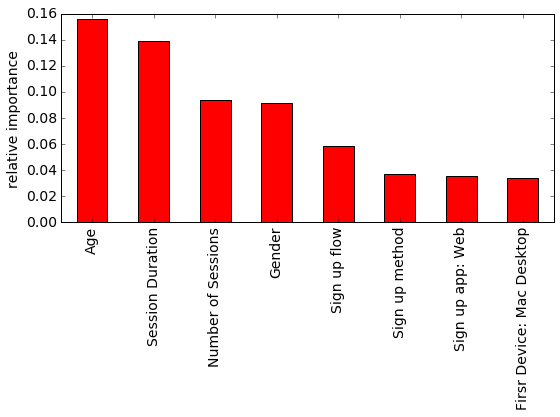

In [160]:
imp_plt = impa[0:8]
plt.rcParams.update({'font.size': 14})
plt.figure()
imp_plt.plot(kind='bar', x='feature', y='importance', legend=False, figsize=(8, 6), color="red")
#plt.title('XGBoost Feature Importance')
plt.ylabel('relative importance')
plt.xlabel('')
#plt.tight_layout(pad=2) 
plt.tight_layout()
#plt.xticks(x, labels, rotation='vertical')
plt.gcf().savefig('/Users/vsokolov/papers/dl-stats/paper/fig/feature_importance_xgb.png', bbox_inches='tight')